In [ ]:
 from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = 'drive/My Drive/data'

In [ ]:
import pandas as pd

In [ ]:
try:
    df = pd.read_csv(path+'/12GEN.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(path+'/12GEN.csv', encoding='ISO-8859-1')
print(df.shape)

(1033, 6)


In [ ]:
df.head(500)

,ID,Name,Stars,Title,Date,Description
0,1.0,William Hong,1,1.0 out of 5 stars\nVery dirty and used. I did...,11-04-2024,Packing already open. CPU in protect case not ...
1,2.0,Amere,1,1.0 out of 5 stars\nTerrible customer service,29-04-2024,I returned the item because it wasnt good nor ...
2,3.0,nascanio,1,1.0 out of 5 stars\nSCAM,22-03-2024,"CPU is bad and used, Today open the box. the c..."
3,4.0,Average consumer,1,1.0 out of 5 stars\nDead on arrival,15-06-2023,After troubleshooting with q-led lights i dedu...
4,5.0,Jason Krawczak,1,1.0 out of 5 stars\nIntel good Amazon bad.,11-05-2024,Amazon sent a broken item to me.
...,...,...,...,...,...,...
495,496.0,Carlos Gonzalez Debia,5,5.0 out of 5 stars\nAparentemente es un buen p...,08-12-2023,Este producto fue comprado en base a la inform...
496,497.0,Tyler S,5,"5.0 out of 5 stars\nGreat buy, when on sale",01-03-2024,This is a great processor and when on sale it ...
497,498.0,Dylan,5,5.0 out of 5 stars\nGreat Performance,14-11-2023,Built a new system with the 14700k for photo/v...
498,499.0,Amazon Customer,5,5.0 out of 5 stars\n20 modern cores per $400,24-01-2024,I bought it to do computations on all cores. T...


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from scipy.special import softmax
import tensorflow as tf

In [ ]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/501M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
import nltk

In [ ]:
example = df['Description'][350]

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
print(example)
sia.polarity_scores(example)

Excelente procesador cumple con las expectativas


{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [ ]:
encoded_text = tokenizer(example, return_tensors='tf')
output = model(**encoded_text)
#scores = output[0][0].detach().numpy()
#scores = softmax(scores)
logits = output.logits
scores = logits[0].numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.10595368, 'roberta_neu': 0.8128063, 'roberta_pos': 0.08124006}


In [ ]:
def polarity_scores_roberta(example):
    # Tokenize the input text
    encoded_text = tokenizer(example, return_tensors='tf',max_length=512, truncation=True)
    # Perform inference (forward pass)
    output = model(encoded_text)
    # Get the logits from the outputs
    logits = output.logits
    # Convert logits to numpy array and apply softmax to get probabilities
    scores = logits[0].numpy()  # Convert the tensor to a numpy array
    scores = softmax(scores)     # Apply softmax to get the probabilities
    # Create a dictionary with the scores
    scores_dict = {
        'roberta_neg': scores[0],  # Probability of negative sentiment
        'roberta_neu': scores[1],  # Probability of neutral sentiment
        'roberta_pos': scores[2]   # Probability of positive sentiment
    }
    return scores_dict

In [ ]:
if 'Description' not in df.columns:
    raise ValueError("The CSV file must contain a 'Description' column.")

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Description']
        myid = row['ID']

        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}

        roberta_result = polarity_scores_roberta(text)

        both = {**vader_result_rename, **roberta_result}

        res[myid] = both

    except  Exception as e :
        print(f'Error processing ID {myid}: {e}')

  0%|          | 0/1033 [00:00<?, ?it/s]

Error processing ID 238.0: 'float' object has no attribute 'encode'
Error processing ID 245.0: 'float' object has no attribute 'encode'
Error processing ID 331.0: 'float' object has no attribute 'encode'
Error processing ID 422.0: 'float' object has no attribute 'encode'
Error processing ID 553.0: 'float' object has no attribute 'encode'
Error processing ID 556.0: 'float' object has no attribute 'encode'
Error processing ID 559.0: 'float' object has no attribute 'encode'
Error processing ID nan: 'float' object has no attribute 'encode'


In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})


In [ ]:
if 'ID' in df.columns and 'Id' in results_df.columns:
    results_df = results_df.merge(df, how='left', left_on='Id', right_on='ID')
else:
    print("Columns 'ID' or 'Id' not found in one of the DataFrames.")

In [ ]:
print(results_df.head())

    Id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0  1.0      0.035      0.830      0.135          0.5455     0.606178   
1  2.0      0.107      0.893      0.000         -0.3412     0.965748   
2  3.0      0.256      0.744      0.000         -0.8209     0.967088   
3  4.0      0.096      0.799      0.105         -0.0516     0.246425   
4  5.0      0.352      0.455      0.193         -0.3400     0.809904   

   roberta_neu  roberta_pos   ID              Name Stars  \
0     0.341340     0.052481  1.0      William Hong     1   
1     0.032098     0.002154  2.0             Amere     1   
2     0.030028     0.002885  3.0          nascanio     1   
3     0.541378     0.212197  4.0  Average consumer     1   
4     0.178543     0.011553  5.0    Jason Krawczak     1   

                                               Title        Date  \
0  1.0 out of 5 stars\nVery dirty and used. I did...  11-04-2024   
1      1.0 out of 5 stars\nTerrible customer service  29-04-2024   
2 

In [ ]:
examples = df['Description'].tolist()

In [ ]:
results_df.to_csv('sentiment_analysis_results.csv', index=False)

In [ ]:
print(results_df)

          Id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0        1.0      0.035      0.830      0.135          0.5455     0.606178   
1        2.0      0.107      0.893      0.000         -0.3412     0.965748   
2        3.0      0.256      0.744      0.000         -0.8209     0.967088   
3        4.0      0.096      0.799      0.105         -0.0516     0.246425   
4        5.0      0.352      0.455      0.193         -0.3400     0.809904   
...      ...        ...        ...        ...             ...          ...   
1020  1028.0      0.000      1.000      0.000          0.0000     0.044559   
1021  1029.0      0.000      0.565      0.435          0.9201     0.001577   
1022  1030.0      0.000      0.629      0.371          0.9698     0.001594   
1023  1031.0      0.043      0.811      0.146          0.7725     0.038383   
1024  1032.0      0.000      0.827      0.173          0.7717     0.066977   

      roberta_neu  roberta_pos      ID              Name Stars 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

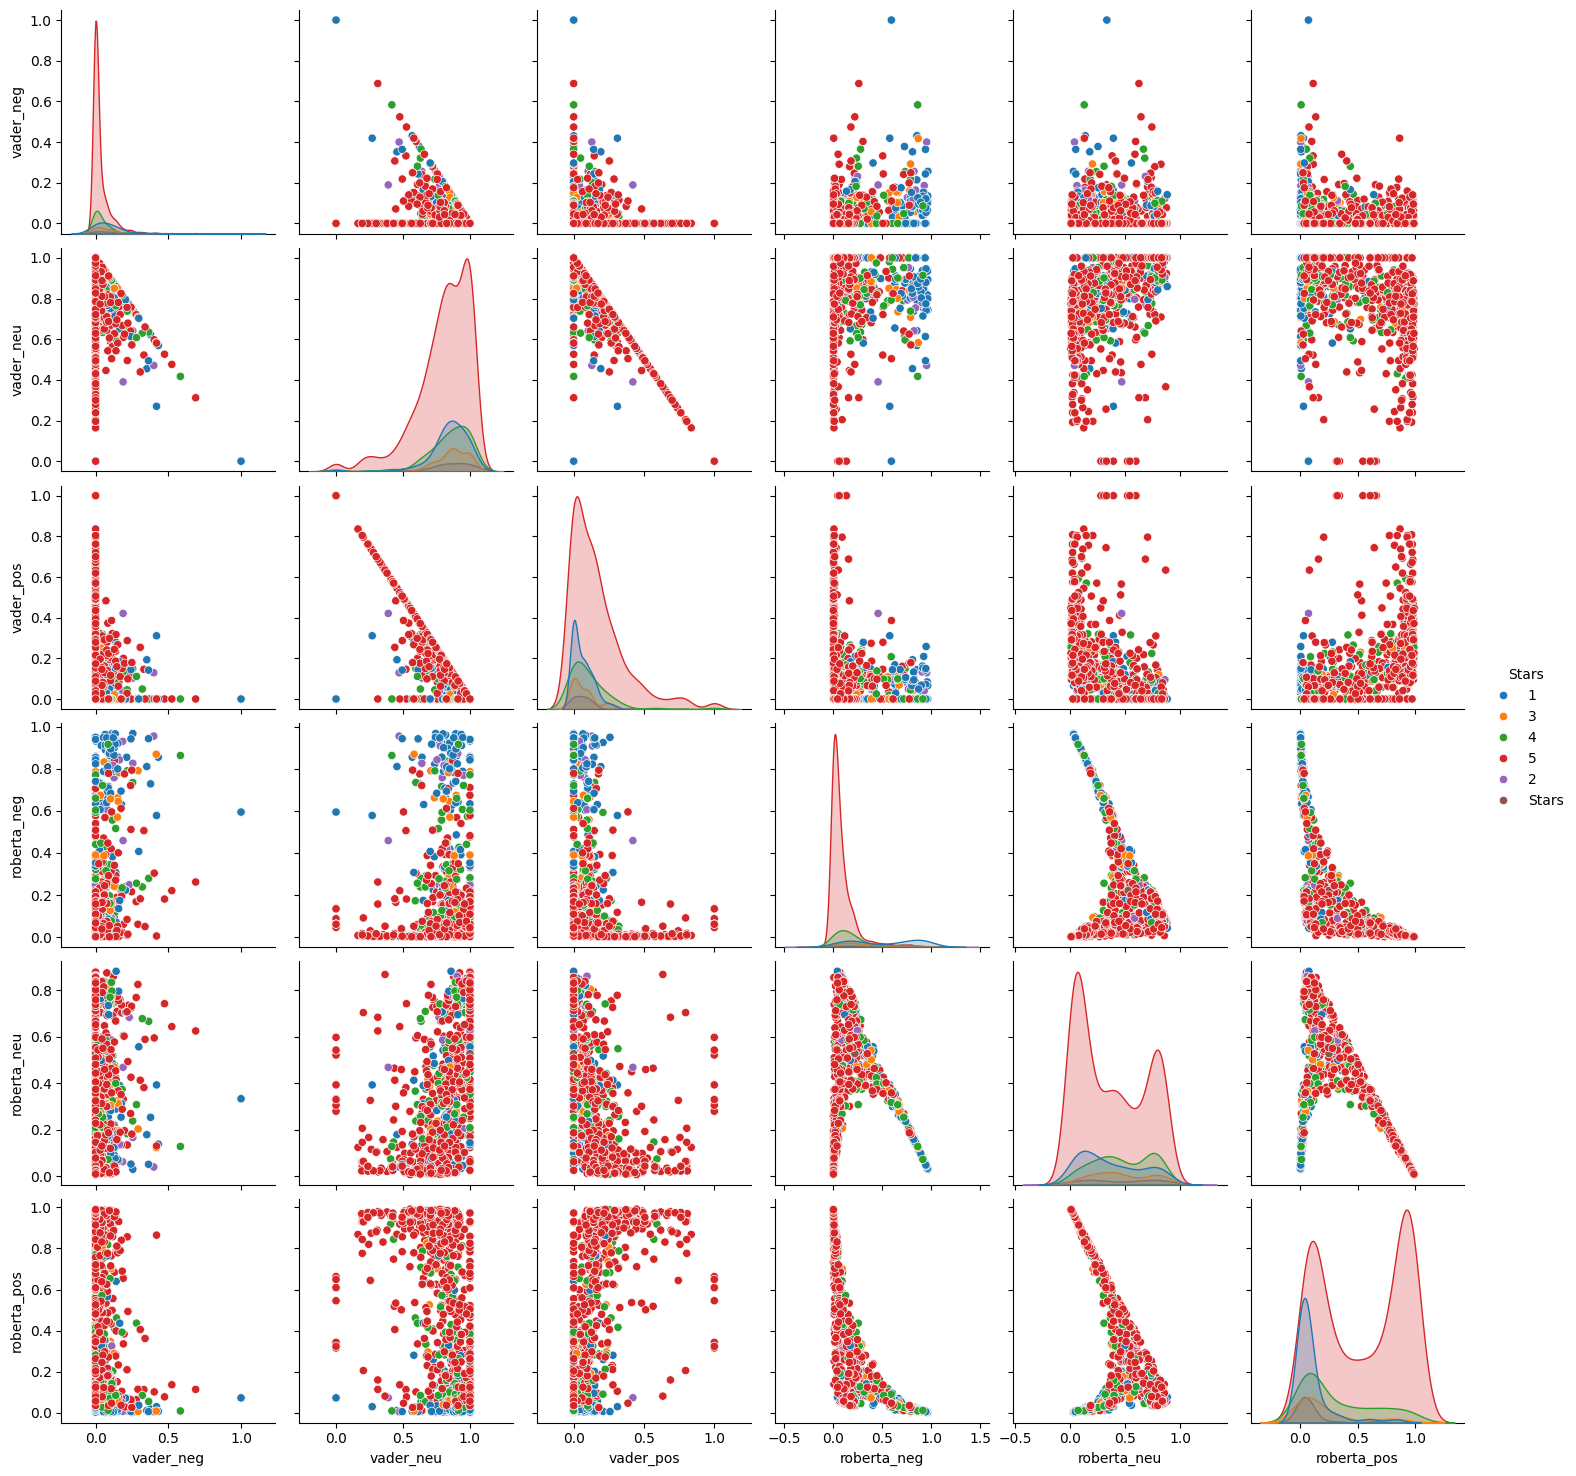

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Stars',
            palette='tab10')
plt.show()

In [ ]:
print(results_df['Stars'].unique())
print(results_df['Stars'].dtype)

['1' '3' '4' '5' '2' 'Stars']
object


In [ ]:
print(results_df['Stars'].head())

0    1
1    1
2    1
3    1
4    1
Name: Stars, dtype: object


In [ ]:
results_df['Stars'] = pd.to_numeric(results_df['Stars'], errors='coerce')

In [ ]:
results_df = results_df.dropna(subset=['Stars'])

In [ ]:
results_df['Stars'] = results_df['Stars'].astype(int)

Printing the contradicting results :

In [ ]:
filtered_df = results_df.query('Stars == 1').sort_values('roberta_pos', ascending=False)

if not filtered_df.empty:
    # Get the first review's description
    first_review = filtered_df['Description'].values[3]
    print(first_review)
else:
    print("No reviews found with a 1-star rating.")

I received a processor in an Intel I box.No markings on the processor itself. Thermal paste residue still on the processor.  This is crazy!!!


In [ ]:
filtered_df = results_df.query('Stars == 1').sort_values('vader_pos', ascending=False)

if not filtered_df.empty:
    # Get the first review's description
    first_review = filtered_df['Description'].values[3]
    print(first_review)
else:
    print("No reviews found with a 1-star rating.")

didnât even come in the box. highly donât recommend


In [ ]:
filtered_df = results_df.query('Stars == 5').sort_values('vader_neg', ascending=False)

if not filtered_df.empty:
    # Get the first review's description
    first_review = filtered_df['Description'].values[3]
    print(first_review)
else:
    print("No reviews found with a 1-star rating.")

LlegÃ³ excelente y sin problemas. Recomendado 100%


In [ ]:
filtered_df = results_df.query('Stars == 5').sort_values('roberta_neg', ascending=False)

if not filtered_df.empty:
    # Get the first review's description
    first_review = filtered_df['Description'].values[3]
    print(first_review)
else:
    print("No reviews found with a 1-star rating.")

This cpu is killer and can literally handle any game you throw at it on max settings, and the same can be said for most workload programs. However I bought it back in early 2022, when it was still way overpriced for what it is now


Code for resolving the issue ( low rating - positive reviews and high rating - negative reviews)

In [ ]:
def adjust_sentiment(row):
    if row['Stars'] <= 2 and row['roberta_pos'] > 0.5:
        return 'Negative'
    elif row['Stars'] >= 4 and row['roberta_neg'] > 0.5:
        return 'Positive'
    else:
        return 'Neutral' if row['vader_neu'] > max(row['vader_pos'], row['vader_neg']) else 'Positive' if row['vader_pos'] > row['vader_neg'] else 'Negative'

In [ ]:
results_df['Adjusted_Sentiment'] = results_df.apply(adjust_sentiment, axis=1)

In [ ]:
results_df.to_csv('adjusted_sentiments.csv', index=False)

The Transformers Pipeline

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [ ]:
example = df['Description'][500]
print(example)
print(df['Stars'][500])

Fast.Runs cool and sips power at idle, guzzles down power when under heavy render load. Gaming is average load and power. Can't complain.More than 6 or 8 cores, won't be limited in the future.Very Fast.Intel APO for 14th gen is a neat new feature which can greatly improve gaming performance.Stable.Memory trains fast and is stable even when pushed well above XMP.Not cheap? But also not expensive for the amount of cores and performance.Would recommend.
5


In [ ]:
sent_pipeline(example)

[{'label': 'POSITIVE', 'score': 0.9980012774467468}]